# Part 2 - Generalized Linear Model

We left the last part with two open questions:

*  We want to predict how a neuron will behave over time. So, how can we model variations in spike probability over time?
* How can we estimate the parameters of such models in a quick & mathematically sound way?

In this part, we begin to adress both these questions by introducing Generalized Linear Models -- models that work much like linear regression, but that can deal with the fact that spike counts are usually not normally distributed. 

We will not explain the theory behind this very general class of statistical model (\*), but we will slowly introduce (in this part and the next) a number of components that allow us to use such models for the prediction of a neural behavior.


<sub>(\*) More about GLMs:</sub>
* <sub>The [wikipedia article about generalized linear models](http://en.wikipedia.org/wiki/Generalized_linear_model) gets difficult to follow very quickly.</sub>
* <sub>Best to go to the source: *McCullagh, Peter; Nelder, John A. Generalized linear models. Vol. 2. London: Chapman and Hall, 1989*. Especially look at **Chapter 2.2:** "The components of a generalized linear model". </sub>

## Loading data

We now load some spike data from the file `data.npz` and -- first of all -- reduce their temporal resolution so that later computations are a bit quicker. Please read the code if you want to know how that works, otherwise just execute this cell.

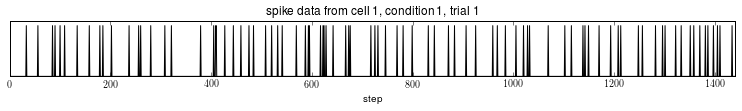

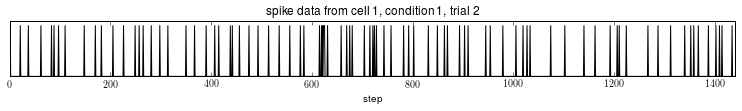

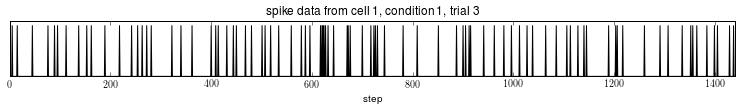

In [35]:
from matplotlib.pyplot import *
%matplotlib inline
import numpy as np
from matplotlib import rc
rc('text', usetex=True)

def reduce_resolution(array,factor,sum_spikes=True):
    """ 
    Reduces the temporal resolution of an array of spike trains.
    
    This can cause multiple spikes to fall into one time bin, i.e. the
    returned array can contain integers > 1.
    If sum_spikes is set to False, we do not sum spike counts. Instead,
    any spike counts > 1 in one bin are truncated down to 1. In that case,
    a binary array is returned, but some spikes may be lost.
    
    Arguments:
        array: 4D numpy array. Reduction will occur along the last dimension (T).
        factor: integer to divide the number of time bins by.
        sum_spikes: If false, truncate the number of spikes per bin to 1.
      
    Returns:
        4D numpy array, similar as input but last dimension with length T/factor.
    """
    assert type(factor) is int
    reduced_shape = (array.shape[0],array.shape[1],array.shape[2],array.shape[3]/np.round(factor))
    spikes_reduced = np.zeros(reduced_shape) # create a shortened result array
    for idx in np.ndindex(array.shape[0:3]): # for all indices along the first 3 dimensions..
        spiketimes = (array[idx].nonzero()[0] / factor).astype(int) # get spiketimes, divide by factor
        for spiketime in spiketimes: # loop manually, since numpy indexing treats index lists as sets
            spikes_reduced[idx[0],idx[1],idx[2],spiketime] += 1 # increment result array by 1 at the divided spiketimes
    
    if not sum_spikes:
        spikes_reduced  = spikes_reduced >= 1
    spikecount_difference = (np.sum(array) - np.sum(spikes_reduced)).astype(int)
    if spikecount_difference > 0:
        print "Lost "+str(spikecount_difference)+" spikes through resolution reduction."
    return spikes_reduced    


# Load the data:
with np.load('data.npz') as archive:
    original_spikes = archive['spikes_outputencoding']

# reduce resolution:
max_spikes_per_bin = 10 # <-- resolution reduction factor
spikes = reduce_resolution(original_spikes,factor=max_spikes_per_bin, sum_spikes=True)

# choose a subset of the data (one cell & one experimental condition):
cell = 1
condition = 1
N = spikes.shape[2] # number of trials
T = spikes.shape[3] # length of a trial
all_spiketrains = spikes[cell,condition,:,:] # N x T array containing only the subset of data that we picked


# Plot some example spike trains:
def plot_spiketrain(trial):
    figure(figsize=(13,1))
    plot(spikes[cell,condition,trial,:],'k')
    title('spike data from cell '+str(cell)+', condition '+str(condition)+', trial '+str(trial))
    up = ylim()[1]
    ylim(0,up+0.1)
    yticks([])
    xlim([0,T])
    xlabel('step')
    
plot_spiketrain(1)
plot_spiketrain(2)
plot_spiketrain(3)

## Simple spline model


As mentioned, we want to estimate -- from these spike trains -- how the firing probability of the neuron changes over time. In this exercise, you will use the generalized linear model framework to fit a spline model. The result will be an estimated firing probability that follows the data flexibly, and that changes smoothly over time.

** TODO: remind everyone of the following basic concepts, possibly in multiple cells:** 

* That these data are binomially distributed.

* That GLMs can be imagined much like linear regression, just that we now estimate the $\mu$ of a binomial distribution instead of that of a normal. 

* Linear models become interesting when you allow nonlinear basis functions. 

* The spline basis functions. 

* Design Matrix. 

* how the 2D input format of the statsmodels.GLM class works (success/failure vectors).

### Exercise 1


# (TODO)
Vorschlag fuer Aufgaben:

* die spikes_nospikes-matrix erzeugen (anhand einer beschreibung wie das format aussieht)
* mit den splinesfunktionen eine augmented knot vector und eben eine splinebasis erzeugen (im text weisen wir explizit auf augnkt und spcol hin)
* GLM fitten

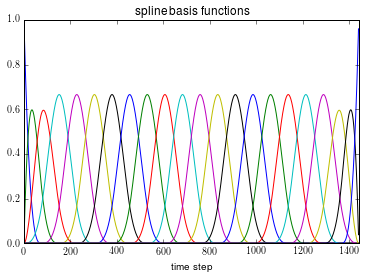

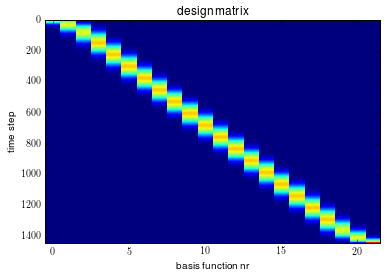

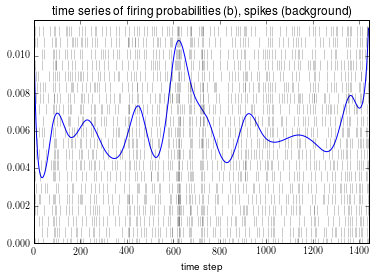

In [84]:
import statsmodels.api as sm
import splines


spike_y,spike_t = np.where(all_spiketrains)

# spikes_across_trials = ...
# spikes_nospikes = ...

# spline_order = ...
# knots = ...
# spline_bases = ...
# dm = ...

# model = sm.GLM(...)
# fitted_model = model.fit()
# prediction = fitted_model.predict(...)

spikes_across_trials = all_spiketrains.sum(axis=0, keepdims=True).T    #solution
spikes_nospikes = np.hstack([spikes_across_trials, N*max_spikes_per_bin-spikes_across_trials])       #solution

spline_order = 3                                                      # solution
knots = splines.augknt(np.linspace(0,T,20), spline_order)
spline_bases = np.array(splines.spcol(range(T),knots,spline_order))   # solution

model = sm.GLM(spikes_nospikes,spline_bases,family=sm.families.Binomial())      # solution
fitted_model = model.fit()                                            # solution
prediction = fitted_model.predict(spline_bases)                       # solution


figure()
plot(spline_bases)
xlim([0,T])
title('spline basis functions')
xlabel('time step')

figure()
imshow(spline_bases,aspect='auto',interpolation='nearest')
title('design matrix')
ylabel('time step')
xlabel('basis function nr')


figure()
plot(prediction)
up = np.max(prediction[10:-10])*1.1
plot(spike_t,spike_y*up/N,"k|", alpha=0.4,ms=10)
ylim(0,up)
xlim([0,T])
title('time series of firing probabilities (b), spikes (background)')
xlabel('time step')

### Filtering

The model you just fitted appears to miss some quick variations in firing rate that seem to be present in the data (e.g. between timestep 600 and 800). We would like to make the model more flexible at times where the neuron changes behaviour, and to spend fewer free parameters in those times where the neuron doesn't change much.

This brings us to a completely different approach to estimating firing rates (already briefly mentioned in part 1), namely **filtering**. Here, this means to [convolve](http://en.wikipedia.org/wiki/Convolution) the spike train with some short, smooth signal such as a [Gaussian curve](http://en.wikipedia.org/wiki/Gaussian_filter). In principle, we could filter all the spike trains in our data set, normalize the resulting curve to some sensible interval between $(0,1)$ and call this our spike probability. This is a [valid approach](http://www.ncbi.nlm.nih.gov/pmc/articles/PMC2783748/#R31), but not the one we take here, since we want more precise control over the model than this method would allow. However, we can **extract some useful information from filtered versions of our spike trains**, which will then help improve the spline model. But first, let's look at what filtering does to a spike train, in principle.

We pick three different filter signals: A gaussian curve, its first derivative and its second derivative. The next plot shows the result of convolving these three signals with a single spike. Incidentally, what you get if apply this operation to a single pulse is excatly the shape of the filter signal.

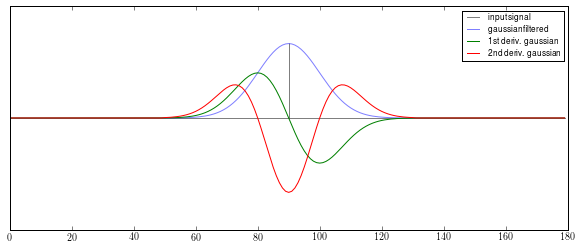

In [56]:
from scipy.ndimage.filters import gaussian_filter1d

sigma = 10 # see what happens if you change this.

def plot_filtered(y, sigma=10, abs=True):
    # Calculate filtered signals for order 0,1,2 and scale them up for plotting
    filtered_O0 = gaussian_filter1d(y, sigma=sigma, order=0)
    filtered_O1 = gaussian_filter1d(y, sigma=sigma, order=1)*sigma
    filtered_O2 = gaussian_filter1d(y, sigma=sigma, order=2)*sigma**2
    
    figure(figsize=(10,4))
    
    vlines(np.argwhere(y),0,0.04,'k',alpha=0.5)
    plot(np.zeros(y.shape),'k',alpha=0.5,label='input signal')
    plot(filtered_O0, "b",label='gaussian filtered',alpha=0.5)
    plot(filtered_O1, "g:" if abs else "g",label='1st deriv. gaussian')
    plot(filtered_O2, ":r" if abs else "r",label='2nd deriv. gaussian')
    
    # If intended, also plot the absolute value of the filtered derivatives
    if abs:
        plot(np.abs(filtered_O1), "g",label='abs. 1st deriv. gaussian')    
    if abs:
        plot(np.abs(filtered_O2), "r",label='abs. 2nd deriv. gaussian') 
    legend(fontsize='small')
    
    ylim([min(filtered_O0.min(),filtered_O1.min(),filtered_O2.min())*1.5,max(filtered_O0.max(),filtered_O1.max(),filtered_O2.max())*1.5])
    yticks([])

signal_length = 180
y = np.zeros((signal_length,))
y[signal_length/2] = 1
plot_filtered(y, sigma=sigma, abs=False)

We now filter a short sequence of spikes. You can observe three things:

* filtering the sequence with a Gaussian filter is like a firing rate estimate (the more dense the spikes, the higher the value)
* filtering with the first derivative of a Gaussian yields the rate of change of that estimate
* filtering with the 2nd derivative of a Gaussian yields its *curvature*

In essence, the derivative-filtered spiketrains tell us at each point in time ** how the spike rate is currenly changing.**

We will mostly be interested only in *how much* it is changing, so we take absolute values of the derivatives.

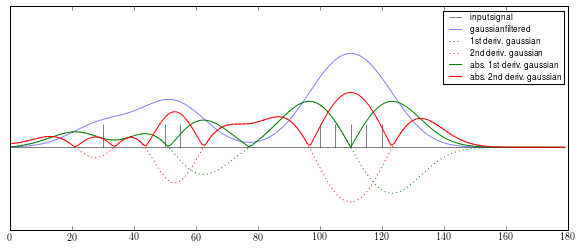

In [57]:
y = np.zeros((signal_length,))
y[[30,50,55,100,105,110,115,120]] = 1
plot_filtered(y, sigma=sigma)

### Exercise 2a

Now let's apply such filters to our spike data.

* Sum up all our spike trains across trials and apply a gaussian filter to the result.
* Sum up all our spike trains across trials and apply the 2nd derivative of a gaussian filter to the result

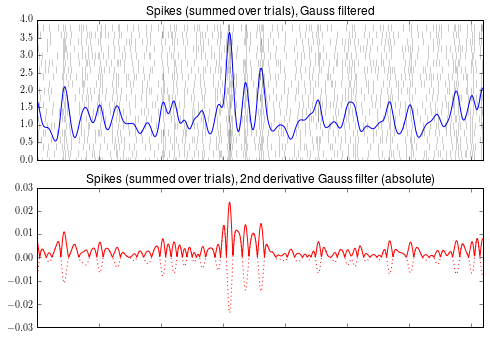

In [72]:
# spiketrain_gauss    = ...
# spiketrain_gauss_d2 = ...

spiketrain_gauss    = gaussian_filter1d(all_spiketrains.sum(axis=0), sigma=sigma, order=0)  # solution
spiketrain_gauss_d2 = gaussian_filter1d(all_spiketrains.sum(axis=0), sigma=sigma, order=2)  # solution




figure(figsize=(8,5.5))
ax1=subplot(2,1,1)
plot(spiketrain_gauss)
up = ylim()[1]
plot(spike_t,spike_y*up/N,"k|", alpha=0.4,ms=7)
title("Spikes (summed over trials), Gauss filtered")

ax2=subplot(2,1,2, sharex=ax1)
plot(spiketrain_gauss_d2,'r:')
plot(np.abs(spiketrain_gauss_d2),'r')
title("Spikes (summed over trials), 2nd derivative Gauss filter (absolute)")
xlim([0,T])


for label in ax1.get_xticklabels() + ax2.get_xticklabels():
    label.set_visible(False) 

## Spline model with adaptive knot vector

This brings us back to our knot vector problem. In essence, we want to distribute a fixed number of points (the knots) in such a way that the firing rate changes by the same absolute amount between any two successive knots. 
In other words, the knots should be close to each other in timespans with a high absolute derivative, less dense elswhere.

Mathematically this means, that given the Gauss-filtered spiketrain $\tilde s(t)$ we want to compute the function 
$D(t) = \int_0^t |\frac{d}{d \tau} \tilde s(\tau)| dt$
(or rather, for vectors in discrete time, we want to calculate the vector
$D[t] = \sum_0^t |\frac{d}{d \tau} \tilde s[\tau]| dt$).

In programming-terms this means that for a spike vector $s$ we want to calculate the so called *cumulative sum* of the vector of absolute values of $s$ after it has been convolved with a derivative-of-Gaussian-filter.

The function $D(t)$ (or the vector $D[t]$) tells us how much *absolute change* in the neuron's firing rate has accumulated until time $t$.
The inverse of that function, $t=D^{-1}(x)$ tells us the time $t$ before which an absolute rate-change of $x$ has accumulated. We want to place our knots such that between each two knots the rate changes by the same absolut amount, i.e. we place our knots at positions $k_i = D^{-1}(\frac{i}{n}) \text{ for } i\in\{0,\dots,n\}$.
Intuitively, that means that each of the knots has to account for the same amount of variability in the neuron's firing rate over time.

*For the curious*: a probability-theoretic intuition:
----------------
Consider the probability that a small change of fixed size in the neuron's firing rate occured before time $t$.
If a fraction $D(t)$ of the total rate changes fall into the time interval $[0,t]$ (and the remaining fraction of $D(T)-D(t)$ rate changes fall into the interval $[t,T]$), then the probability of a small change to fall into the interval $[0,t]$ is again just $D(t)$.
Thus you can think of $D(t)$ as the cumulative distribution function of a random variable $X$ with density $d$ that encodes where during the trial a rate change is most likely to occur.

If we chose our knots as described above, ie. as $k_i = D^{-1}(\frac{i}{n}) \text{ for } i\in\{0,\dots,n\}$, then the probability that the time $X$ of a small rate change of fixed size lies between two knots $k_i$ and $k_{i+1}$ is just $P(X<k_{i+1}) - P(X<k_i) = P(X<D^{-1}(\frac{i+1}{n})) - P(X<D^{-1}(\frac{i}{n})) =  P(D(X)< \frac{i+1}{n}) - P(D(X)<\frac{i}{n}) = \frac{i+1}{n} - \frac{i}{n} = \frac{1}{n} = \text{const.}$.

This last result follows from the fact that for a random variable $X$ with density $D_X$ the random variable $D_X(X)$ is a uniform random variable. If you are interested, you can [read why that is, here.](http://en.wikipedia.org/wiki/Probability_integral_transform).

### Exercise 2b

* implement the function `calc_cum_abs_deriv` that:
    * filters a given signal `s` with a Gaussian filter derivative of order `order` with standard deviation `sigma`
    * calculates the absolute value of the filtered spike train
    * calculates and returns the cumulative sum of the result
* use the function `calc_cum_abs_deriv` to calculate the cumulative absolute first derivative of `total_spikes`

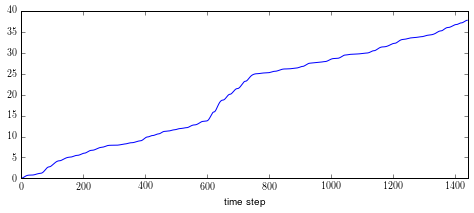

In [73]:
def calc_cum_abs_deriv(y, sigma=10, order=1):
    """ Calculates the curvature of the spike count vector `y`"""
    # your code here
    return np.cumsum(np.abs(gaussian_filter1d(y, sigma=sigma, order=order)))    # solution

#cumulative_derivative = ...
cumulative_derivative = calc_cum_abs_deriv(all_spiketrains.sum(axis=0), sigma=sigma, order=1) # solution


figure(figsize=(8,3))
plot(cumulative_derivative)
xlim([0,T])
xlabel('time step')

As explained above, we now want to adaptively place knots at positions $k_i = D^{-1}(\frac{i}{n}) \text{ for } i\in\{0,\dots,n\}$, i.e. at the percentiles $\frac{i}{n}$.

The function `find_percentiles` defined below can be used to approximate, for a vector `y`, 
`num_percentiles` positions $k_i$ where $y[k_i] \approx \frac{i}{n}$.

### Exercise 2b
* try to understand what the function `find_percentiles` does
* use the function `find_percentiles` (with the option `return_thresholds` argument) to calculate the knot position vector `adaptive_rate_knots` and the correspond vector `percentiles`


(0, 1450)

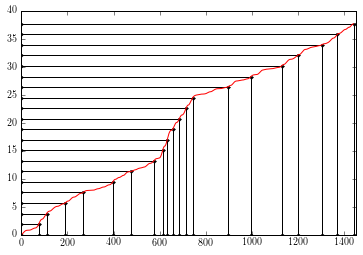

In [82]:
def find_percentiles(y, num_percentiles, return_thresholds=False):
    """ Finds `num_percentiles` equally spaced percentiles of `y` (a monotonically increasing vector),
    i.e. it approximates the inverse `x` of the function `y=f(x)` 
    at `num_percentiles` equally spaced `y`-values between 0 and `y[-1]`.
    
    Arguments:
        y:                  a sequence of monotonically increasing function values
        num_percentiles:    number of percentiles to find between 0 and `y[-1]`.
        return_threshold:   boolean value to indicated whether or not to return the thresholds, too
    Returns:
        percentiles:        `y`-values of the percentiles
        [thresholds:        `x`-values of the percentiles]
    """
    thresholds = np.linspace(0,y[-1],num_percentiles+1)
    percentiles = np.zeros_like(thresholds)
    
    current = 1
    for step in range(T):
        if y[step] > thresholds[current]:
            percentiles[current] = step
            current +=1
    
    percentiles[-1] = len(y)
    if return_thresholds:
        return percentiles, thresholds
    else:
        return percentiles

    
num_knots = 20
#adaptive_rate_knots, percentiles = ...
adaptive_rate_knots, percentiles = find_percentiles(cumulative_derivative, num_knots, return_thresholds=True)


figure()
for px,py in zip(adaptive_rate_knots, percentiles):
    plot([0,px,px],[py,py,0],'k.-')
    
plot(cumulative_derivative,'r')
xlim([0,T+10])

The red line in the plot above shows the cumulative absolute derivative of the smoothed spike train $D(t)$ over the course of one trial.
You should see how the knots are placed at positions $k_i$ such that the function values $D(k_i)$ at the knot positions are evenly spaced. The knots are placed more densely in regions where the neuron's firing rate changes quickly (have a look again at the firing rates you plotted in exercise 2a).

## Spline model with an adaptive knot vector

### Exercise 2c

In exercise 1 you fitted a rate model with linearly spaced splines to our spike train data.
In exercise 2b we just used a more sophisticated way of placing the knots for our model.

* fit a rate model just like in exercise 1, only this time using the knots given by the vector `adaptive_rate_knots` (which you calculated in the previous cell) instead of generating linearly spaced knots
* can you see a qualitative difference in the fit produced by the models in this exercise and the one in exercise 1?

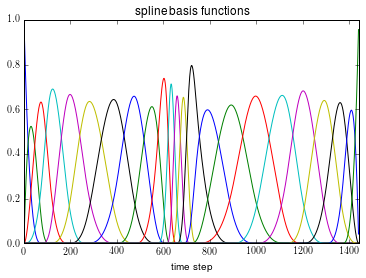

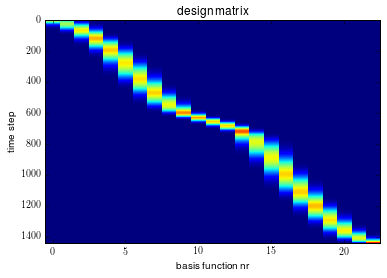

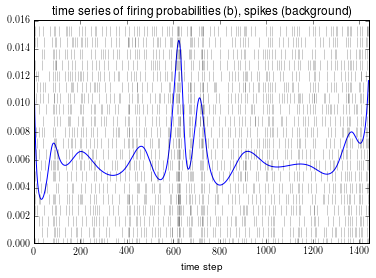

In [86]:
spikes_across_trials = all_spiketrains.sum(axis=0, keepdims=True).T    #solution
spikes_nospikes = np.hstack([spikes_across_trials, N*max_spikes_per_bin-spikes_across_trials])       #solution

spline_order = 3                                                      # solution
knots = splines.augknt(adaptive_rate_knots, spline_order)

spline_bases = np.array(splines.spcol(range(T),knots,spline_order))   # solution
model = sm.GLM(spikes_nospikes,spline_bases,family=sm.families.Binomial())      # solution
fitted_model = model.fit()                                            # solution
prediction = fitted_model.predict(spline_bases)                       # solution

# again plot basis functions, design matrix and the model prediction:
figure()
plot(spline_bases)
xlim([0,T])
title('spline basis functions')
xlabel('time step')

figure()
imshow(spline_bases,aspect='auto',interpolation='nearest')
title('design matrix')
ylabel('time step')
xlabel('basis function nr')

figure()
plot(prediction)
up = np.max(prediction[10:-10])*1.1
plot(spike_t,spike_y*up/N,"k|", alpha=0.4,ms=10)
ylim(0,up)
xlim([0,T])
title('time series of firing probabilities (b), spikes (background)')
xlabel('time step')

## Finding the right number of knots

## Exercise 3

In exercises 1 and 2 we have now seen two different ways of creating a knot-vector for the splines in our rate models:

 1. **linearly spaced knots**, i.e. the distance between each two successive knots is the same
 2. **adaptively spaced knots**, i.e. the total firing-rate-change between each two successive knots is the same

As if deciding between these two types of knot-vectors wasn't enough of a problem already, we also don't know yet **how many** knots to use. To make a principled decision about what size and type of knot-vector to choose,
we can use *model-selection* techniques such as cross-validation or, in our case, **AIC**.

As explained in the morning session, calculating the AIC-value of multiple different models and picking the model that achieves the lowest AIC values is a good way of finding a model that yields a good balance between *underfitting* on the training data and *overfitting* on the test data. We hope that using AIC we can find a model that has a high likelihood (*goodness-of-fit*) but only uses few spline-basis functions for that (low *model-complexity*).

Your task now is:

* for each `num_knots` in the list `num_knots_candidates` do the following:
    * fit a rate model with `num_knots` linearly spaced knots (like in exercise 1)
    * store the model prediction for one trial as `prediction_linear_knots`
    * append the AIC-value of this model to the list `linear_AICs`
    * calculate a vector of `num_knots` adaptively spaced knots
    * fit a rate model using the vector adaptively spaced knots (like in exercise 2)
    * store the model prediction for one trial as `prediction_adaptive_knots`
    * append the AIC-value of this model to the list `adaptive_AICs`
* find the combination of number of knots and type of knot vector ("linear" or "adaptive") for which you got the lowest AIC-value

**Hint 1:** Luckily the `statsmodels` package that we are using already computes the AIC-value of a model while fitting it, so to determine the AIC of `fitted_model` you can just used `fitted_model.aic`.

**Hint 2:** You can just use the vector `cumulative_derivative` and the function `find_percentiles` from exercise 2 for calculating the adaptively spaced knot positions.

**Hint 3:** you can use the [ternary-operator](https://docs.python.org/3.3/faq/programming.html#is-there-an-equivalent-of-c-s-ternary-operator) to quickly set a variable to one value if a condition is satisfied or to another value if that condition is not satisfied

Number of splines: 50
Number of splines: 80
Number of splines: 100
Number of splines: 120
Number of splines: 150


ValueError: attempt to get argmax of an empty sequence

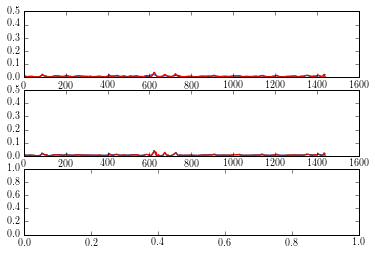

In [95]:
#def ll(ps,xs):
#    ...

# Create a figure with 3 subplots into which we will plot some model predictions
# and a comparison of the AIC-values of the different models
figure()
ax1 = subplot(3,1,1)
ax2 = subplot(3,1,2)
ax3 = subplot(3,1,3)

num_knots_candidates = [50,80,100,120,150]
linear_AICs   = []
adaptive_AICs = []

#for ...:
#    print "Number of splines: %d" % num_knots
#    # fit model with linearly spaced knots:
#    # YOUR CODE HERE
#    #prediction_linear_knots = ...
#    
#    # fit model with adaptively spaced knots:
#    # YOUR CODE HERE
#    #prediction_adaptive_knots = ...
#    
#    if num_knots in [50,100,150]:
#        ax1.plot(prediction_linear_knots)
#        ax2.plot(prediction_adaptive_knots)

#best_type = "linear" if ... else "adaptive"
#best_num_knots = ...

for num_knots in num_knots_candidates:
    print "Number of splines: %d" % num_knots
    # fit model with linearly spaced knots:
    knots        = splines.augknt(np.linspace(0,T,num_knots), spline_order)
    spline_bases = np.array(splines.spcol(range(T),knots,spline_order))
    model        = sm.GLM(spikes_nospikes,spline_bases,family=sm.families.Binomial())
    fitted_model = model.fit()
    linear_AICs.append(fitted_model.aic)
    prediction_linear_knots   = fitted_model.predict(spline_bases)
    
    # fit model with adaptively spaced knots:
    adaptive_rate_knots = find_percentiles(cumulative_derivative, num_knots)
    knots        = splines.augknt(adaptive_rate_knots, spline_order)
    spline_bases = np.array(splines.spcol(range(T),knots,spline_order))
    model        = sm.GLM(spikes_nospikes,spline_bases,family=sm.families.Binomial())
    fitted_model = model.fit()
    linear_AICs.append(fitted_model.aic)
    prediction_adaptive_knots   = fitted_model.predict(spline_bases)
    
    if num_knots in [50,100,150]:
        ax1.plot(prediction_linear_knots)
        ax2.plot(prediction_adaptive_knots)
        
best_linear_idx   = np.argmax(linear_AICs)
best_adaptive_idx = np.argmax(adaptive_AICs)

best_type = "linear" if linear_AICs[best_linear_idx] < adaptive_AICs[best_adaptive_idx] else "adaptive"
best_num_knots = num_knots_candidates[best_linear_idx] if best_type == "linear" else num_knots_candidates[best_adaptive_idx]

print "The best model was the model with %s spacing and %d knots" % (best_type,best_num_knots)

# Summary & Outlook

**(TODO turn keywords into proper text)**

* Linear model with nonlinear (spline) basis functions to get a flexible model of variations over time
* Strength of the spline model is that we can control where it is flexible, where not. We informed that through a filtering-based approach, which gave us a rough estimate of where the firing rate changes quickly.


Next, we add some additional model components to increase accuracy:
* auto-history of each cell (to account e.g. for the refractory period)
* cross-history (to modulate a cell's firing probability based on the behaviour of other cells)